In [1]:
import sys
from pathlib import Path, PureWindowsPath
current_folder = PureWindowsPath(globals()['_dh'][0]).as_posix()
path_root = "/".join(current_folder.split("/")[:-3]) #remonter au dossier root du projet
os.chdir(path_root)
print(os.getcwd())
sys.path.append(os.getcwd() + "/sources/classification/")

c:\Users\eupho\OneDrive\Documents\perso\projets\classification_texte_bapteme_philo


In [22]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score 
from gensim.utils import tokenize
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from pathlib import Path, PureWindowsPath
from lib_classification import *
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 5)
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans dataframe

In [3]:
path = PureWindowsPath(os.getcwd() + "/data/input/data_philosophy_baptism.parquet")
path = path.as_posix() #convertir en path linux (convertir les \\ en /)
corpus = pd.read_parquet(path) #engine="fastparquet"
corpus = get_balanced_binary_dataset(corpus, class_col_name="category")

print(corpus["category_bin"].value_counts())
print("presence de doublons ?")
print(corpus.id.duplicated().any())
print(corpus.index.duplicated().any())
corpus

1    1833
0    1833
Name: category_bin, dtype: int64
presence de doublons ?
False
False


,id,message,message_preprocessed,category,length,category_bin
0,0,Dieu pourrait-il rendre l’homme mieux que ce qu’il est déjà ? Oui et non.,dieu pourrait-il rendre homme mieux déjà oui non,philosophy,73,1
1,1,"Les réformés ne rebaptisent pas car le baptême c’est Dieu lui-même qui promet. Ce serait remettre en doute sa Parole et sa promesse, d’où le fait que Zwingle dise, non sans excès, qu’il s’agisse de « recrucifier » le Fils.",réformé rebaptisent car baptême dieu lui-même promet remettre doute parole promesse où fait zwingle dise non sans excès agisse « recrucifier » fil,baptism,222,0
...,...,...,...,...,...,...
3664,3664,"Si vous voulez lire et vous informer sur les réponses des réformés aux anabaptistes, [cet article de Yannick Imbert analyse leurs réponses historiques](https://larevuereformee.net/articlerr/n277/les-critiques- reformees-de-lanabaptisme).",si voulez lire informer réponse réformé anabaptiste cet article yannick imbert analyse leurs réponse historiqueshttpslarevuereformeenetarticlerrnles-critiques- reformees-de-lanabaptisme,baptism,237,0
3665,3665,2. [Le Catéchisme de Heidelberg – Histoire et Texte. – PAR LA FOI](https://parlafoiblog.wordpress.com/2018/01/10/le-catechisme-de-heidelberg/) \- […] >>Lisez : 10 bonnes raisons d’être pédobaptiste ! […],catéchisme heidelberg – histoire texte – foihttpsparlafoiblogwordpresscomle-catechisme-de-heidelberg - … lisez bonne raison être pédobaptiste …,baptism,205,0


In [4]:
tokens = corpus["message_preprocessed"].apply(word_tokenize)
model_skip_gram = Word2Vec(sentences=tokens, vector_size=200,workers=-1, sg=0) #modele cbow
model = model_skip_gram

Utilisation des features word2vec pour la classification

Creation features du modele : moyenne des "mots" d'une phrase

In [5]:
words_vectors_skip_gram = model_skip_gram.wv
vocab = model_skip_gram.wv.index_to_key
corpus_average_vectors = []
sentence_average_vector = []
sentence_vectors = []
vector_space_dim = 200

for i in range(len(tokens)):
    sentence = tokens[i]
    sentence_words = list(set(vocab) & set(sentence))
    if(sentence_words != []):
        sentence_average_vector = np.mean(words_vectors_skip_gram[sentence_words], axis=0)
        # print("words_vectors_skip_gram[sentence_words] =", words_vectors_skip_gram[sentence_words])
    else:
        print("sentence =", sentence)
        print("sentence_words =", sentence_words)
        sentence_average_vector = np.zeros(vector_space_dim)
    corpus_average_vectors.append(sentence_average_vector)
# print("len(sentence_vectors) =", len(sentence_vectors))
# print("sentence_vectors =", sentence_vectors)
# print("len(sentence_average_vector) =", len(sentence_average_vector))
# len(corpus_average_vectors)
corpus_word2vec_sk = pd.DataFrame(corpus_average_vectors)
corpus_word2vec_sk['id'] = corpus['id']
corpus_word2vec_sk['message'] = corpus['message']
corpus_word2vec_sk["category_bin"] = corpus["category_bin"]
# corpus_word2vec_sk

sentence = ['tortarolohttpssecuregravatarcomavatarbaddffbdfaefbsdmmrg']
sentence_words = []


In [6]:
X = corpus_word2vec_sk.iloc[:, np.r_[0:200]]
y = corpus_word2vec_sk["category_bin"]
indices = corpus["id"]
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)

In [7]:
# Cross validation avec fonction automatisee
# Modeles utilisés dans les papiers :
# LogisticRegression, MultinomialNB (= naive bayes), SVC (SVD petit data), SGDClassifier (SVD grand data)
# DecisionTreeClassifier, RandomForestClassifier
# AdaBoostClassifier, MLPClassifier
# scoring = ['accuracy', 'precision', 'recall', 'f1', 'f1_macro']
scoring = ['accuracy', 'f1_macro']
num_iter = 2
k = 10
do_cross_validation(X_train, y_train, scoring, num_iter, k)

[('test_accuracy', 0.5122), ('test_f1_macro', 0.3387)] (LR)
[('test_accuracy', 0.7561), ('test_f1_macro', 0.7558)] (AdaBoostClassifier)
[('test_accuracy', 0.6726), ('test_f1_macro', 0.6487)] (KNN)
[('test_accuracy', 0.7962), ('test_f1_macro', 0.7955)] (RandomForest)
[('test_accuracy', 0.5034), ('test_f1_macro', 0.3405)] (SGDClassifier)
[('test_accuracy', 0.8522), ('test_f1_macro', 0.8519)] (SVM)
[('test_accuracy', 0.6323), ('test_f1_macro', 0.6316)] (DecisionTreeClassifier)


c:\Users\eupho\OneDrive\Documents\perso\projets\classification_texte_bapteme_philo/sources/classification\lib_classification.py:111: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels([false_label, true_label], Fontsize=font_size + 3)
c:\Users\eupho\OneDrive\Documents\perso\projets\classification_texte_bapteme_philo/sources/classification\lib_classification.py:112: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_yticklabels([false_label, true_label], Fontsize=font_size + 3)


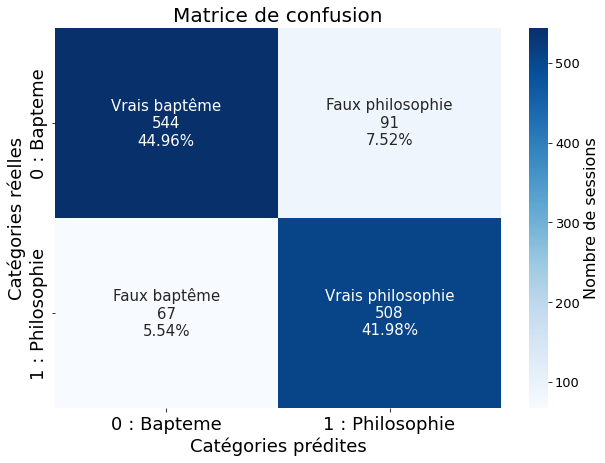

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# model_cbow
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_confusion_matrix(y_test, y_pred, model)

In [9]:
# Metriques
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       635
           1       0.85      0.88      0.87       575

    accuracy                           0.87      1210
   macro avg       0.87      0.87      0.87      1210
weighted avg       0.87      0.87      0.87      1210



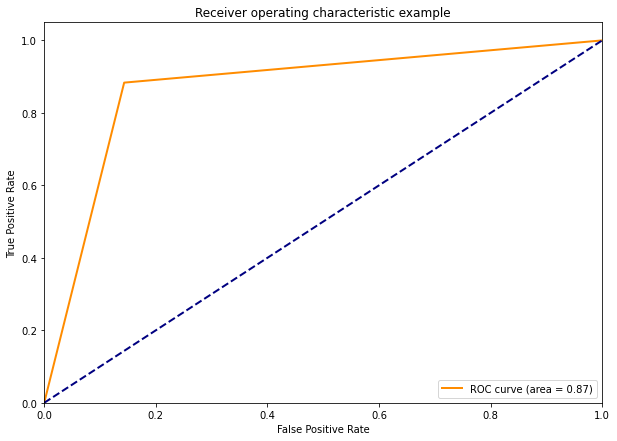

In [17]:
# Courbe ROC et AUC
plot_roc(y_test, y_pred)

sources :
http://ethen8181.github.io/machine-learning/keras/text_classification/word2vec_text_classification.html

In [18]:
k = 10
# kfold = StratifiedKFold(n_splits=k, random_state=None, shuffle=True) #n_splits = k de la k-fold cv, le nombre de fold
kfold = RepeatedStratifiedKFold(n_splits=k, n_repeats=2, random_state=None)
scoring = 'accuracy'
cv_param = kfold
num_experiences = 10
train_sizes = np.linspace(0.1, 1.0, num_experiences)
# train_sizes = np.linspace(0.001, 1.0, num_experiences)
n_jobs = -1

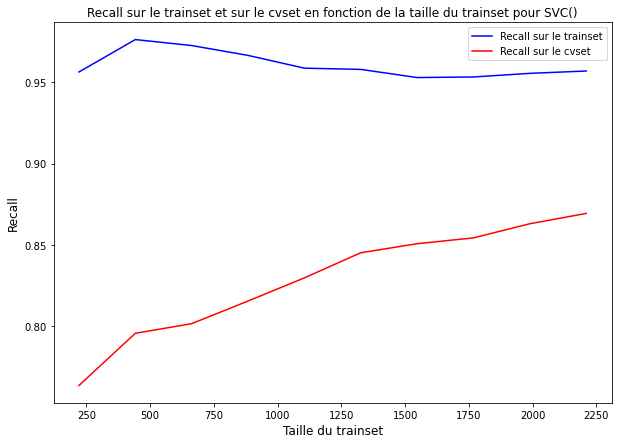

In [12]:
model = SVC() #le meilleur modele garde apres cross validation 
get_learning_curve(model, X_train, y_train, cv_param, "recall", train_sizes, n_jobs)

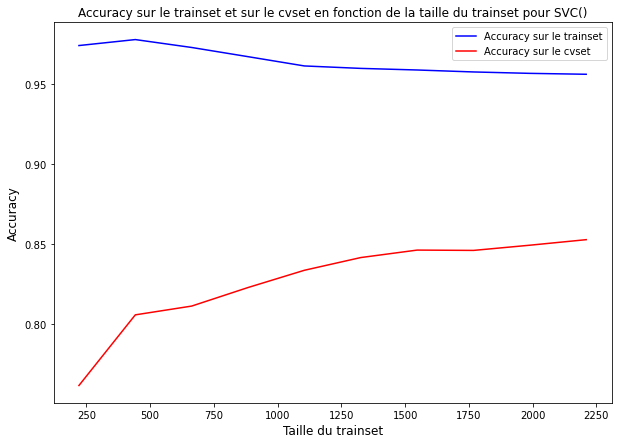

In [13]:
get_learning_curve(model, X_train, y_train, cv_param, "accuracy", train_sizes, n_jobs)

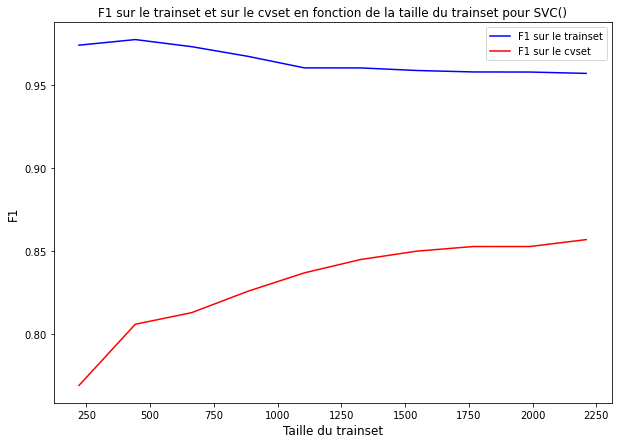

In [14]:
get_learning_curve(model, X_train, y_train, cv_param, "f1", train_sizes, n_jobs)

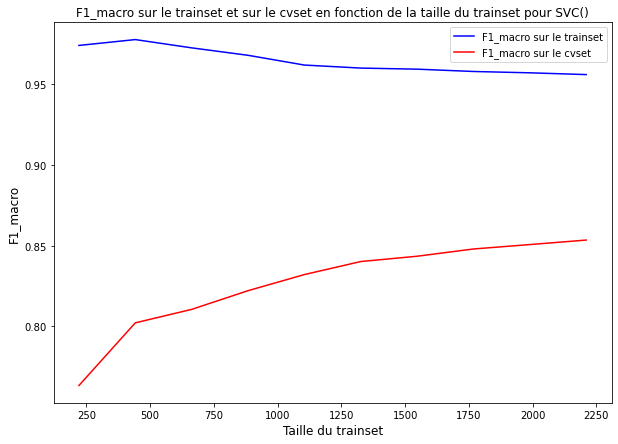

In [15]:
get_learning_curve(model, X_train, y_train, cv_param, "f1_macro", train_sizes, n_jobs)

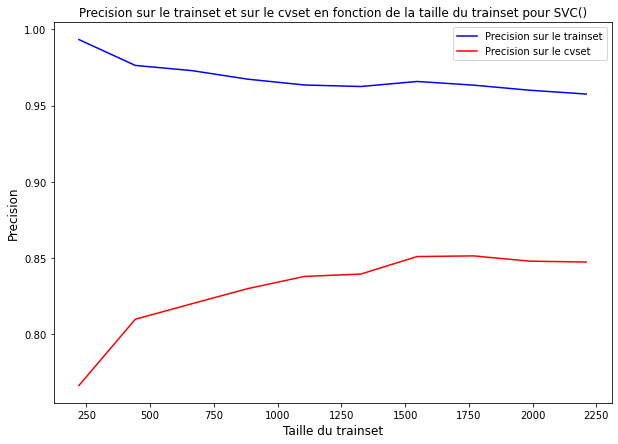

In [16]:
get_learning_curve(model, X_train, y_train, cv_param, "precision", train_sizes, n_jobs)

In [19]:
# On affiche les documents a propos desquels le modele s'est trompe
corpus_test = pd.DataFrame({"id":corpus.iloc[indices_test].id, "message": corpus.iloc[indices_test].message, "truth":y_test, "pred":y_pred})
corpus_test_errors = corpus_test.query("truth != pred")
print(corpus_test.shape)
print(corpus_test_errors.shape)
# corpus_test_errors = corpus_test_errors[["truth", "pred", "message_preprocessed"]]
print(corpus_test_errors.columns)
corpus_test_errors = corpus_test_errors[["id", "truth", "pred", "message"]]
# corpus_test_errors

(1210, 4)
(158, 4)
Index(['id', 'message', 'truth', 'pred'], dtype='object')


In [25]:
with pd.option_context("display.max_rows", 1000):
    display(corpus.iloc[corpus_test_errors[corpus_test_errors["pred"] == 1].id]) 

,id,message,message_preprocessed,category,length,category_bin
1462,1462,La Genèse ! Le salut ! La foi ! Tout est lié !,genèse salut foi tout lié,baptism,46,0
538,538,"Josué 6:25 : « Josué laissa la vie à Rahab la prostituée, **à la maison de son père** , et à tous ceux qui lui appartenaient; elle a habité au milieu d’Israël jusqu’à ce jour, parce qu’elle avait caché les messagers que Josué avait envoyés pour explorer Jéricho. »",josué « josué laissa vie rahab prostitué maison père tous ceux appartenaient a habité milieu israël jour parce caché messager josué envoyé explorer jéricho »,baptism,264,0
3026,3026,À qui « l’Évangile » a-t-il été annoncé d’avance ? À Abraham (Ga 3.8).,« évangile » a-t-il annoncé avance abraham ga,baptism,70,0
3007,3007,"""Moi et ma maison"" : la formule en oikos – Joachim Jeremias",maison formule oikos – joachim jeremias,baptism,59,0
2917,2917,"1. **La régénération baptismale** est la croyance que l’application d’eau au nom de la Trinité sur une personne est la cause instrumentale de sa régénération. Par régénération, on entend le changement de nature (ou plutôt d’ _habitus_ ) de la personne sous l’action du Saint-Esprit. Cette régénération n’est autre que « l’oeuvre souveraine du Saint-Esprit transformant le coeur » pour citer Guillaume Bourin, _[Je répandrai sur vous une eau pure](http://leboncombat.fr/regeneration/)._",régénération baptismale croyance application eau nom trinité personne cause instrumentale régénération régénération entend changement nature plutôt habitus personne sou action saint-esprit cette régénération autre « oeuvre souverain saint-esprit transformant coeur » citer guillaume bourin répandrai eau purehttpleboncombatfrregeneration,baptism,487,0
149,149,(Ils y donnent les critères de validité et distinguent validité et régularité),donnent critère validité distinguent validité régularité,baptism,78,0
1813,1813,"L’être humain est un être rationnel, il est appelé par Dieu à devenir sage, tout d’abord en craignant Dieu, puis en se conduisant d’une manière cohérente avec la création dans laquelle Dieu l’a placé. La sagesse ne s’acquiert pas en mettant les bonnes lunettes mais en analysant, en confrontant, en se trompant et en recommençant.",lêtre humain être rationnel appelé dieu devenir sage tout abord craignant dieu puis conduisant manière cohérente création laquelle dieu a placé sagesse acquiert mettant bonne lunette analysant confrontant trompant recommençant,baptism,330,0
2647,2647,Il n’y aurait aucun témoignage pédobaptiste avant le début du IIIème siècle dans la littérature patristique.,aucun témoignage pédobaptiste avant début iiième siècle littérature patristique,baptism,108,0
3227,3227,"Q. 77: Où Christ a-t-il promis aux croyants de les nourrir de son corps et de les désaltérer de son sang, aussi certainement qu’ils mangent de ce pain rompu et boivent de cette coupe?",q où christ a-t-il promis croyant nourrir corps désaltérer sang aussi certainement mangent pain rompu boivent cette coupe,baptism,183,0
351,351,"Mais c’est tout à fait faux, car au contraire aucun être humain n’est plus proche de Dieu qu’un autre. La présence de Dieu est rendue palpable par Son peuple. Quand les parents disent à leur nouveau-né : « Jésus t’aime et prendra soin de toi », ils parlent des promesses de Dieu.",tout fait faux car contraire aucun être humain plus proche dieu autre présence dieu rendue palpable peuple quand parent disent nouveau-né « jésus aime prendra soin » parlent promesse dieu,baptism,279,0


In [24]:
with pd.option_context("display.max_rows", 1000):
    display(corpus.iloc[corpus_test_errors[corpus_test_errors["pred"] == 0].id])

,id,message,message_preprocessed,category,length,category_bin
869,869,"Thomas d’Aquin mentionne alors la prophétie d’Esaïe qui indique que non seulement la vierge concevra un enfant, mais qu’elle enfantera un fils (sous- entendu : en restant vierge). Par-dessus, il rajoute :",thomas aquin mentionne alors prophétie esaïe indique non seulement vierge concevra enfant enfantera fil sous- entendu restant vierge par-dessus rajoute,philosophy,204,1
2775,2775,"> Obj: Il semble qu’aucun nom ne convienne à Dieu, car, dit Denys : “ Il n’y a > de lui ni nom ni connaissance. ” Et les Proverbes (30, 4) : “ Quel est son > nom et quel est le nom de son fils, si tu le sais ? ” > > Réponse: On doit dire que Dieu est dit n’avoir pas de nom, ou être au-dessus > de tout nom en ce sens qu’il est au-dessus de ce que nous connaissons de lui > et que nous exprimons par nos paroles.",obj semble aucun nom convienne dieu car dit denys “ a ni nom ni connaissance ” proverbe “ quel nom quel nom fil si sais ” réponse doit dire dieu dit avoir nom être au-dessus tout nom sens au-dessus connaissons exprimons parole,philosophy,412,1
1042,1042,"Cette distinction semble avoir un fort soutien biblique. Voici un exemple de la puissance absolue de Dieu : « Et ne prétendez pas : ‘Nous avons Abraham pour père’, car je vous le dis, Dieu est capable, de ces pierres, de susciter des enfants d’Abraham » (Mt 3,9).",cette distinction semble avoir fort soutien biblique voici exemple puissance absolue dieu « prétendez ‘ abraham car dis dieu capable pierre susciter enfant abraham » mt,philosophy,263,1
1912,1912,"Un genre est une « famille » d’espèces. Ainsi, le genre « quadrilatères » abritent des losanges, des carrés, des rectangles, des trapèzes… Un carré est une composition de genre -quadrilatères- et de différences -angles droits contrairement aux losanges, côtés de même longueurs contrairement aux rectangles etc-.",genre « famille » espèce ainsi genre « quadrilatère » abritent losange carré rectangle trapèzes… carré composition genre -quadrilatères- différence -angles droit contrairement losange côté longueur contrairement rectangle etc-,philosophy,312,1
120,120,"Mais par le mode de gouvernement extérieur, il peut y en avoir d’autres que Christ qui sont têtes de leurs églises, mais selon les nuances suivantes :",mode gouvernement extérieur peut avoir autres christ tête leurs église selon nuance suivant,philosophy,150,1
26,26,"Pour qu’il soit manifeste que l’homme ne pouvait pas se sauver lui-même. Ainsi sur Ga 3.19, la Glose (=commentaire « officiel » de la Bible au XIIIe siècle) dit : « C’est par une haute prudence qu’après la chute de l’homme, le Fils de Dieu n’a pas été envoyé aussitôt. En effet, Dieu a d’abord laissé l’homme à son libre arbitre, afin de lui faire connaître ainsi les forces de sa nature. Puis, à cause de son incapacité, l’homme reçut la loi. Ensuite sa maladie s’aggrava, non par la faute de la loi, mais par celle de sa nature viciée; ainsi, connaissant sa faiblesse, il appellerait le médecin et rechercherait le secours de la grâce. »",manifeste homme pouvait sauver lui-même ainsi ga glose commentaire « officiel » bible xiiie siècle dit « haute prudence après chute homme fil dieu a envoyé aussitôt effet dieu a abord laissé homme libre arbitre afin faire connaître ainsi force nature puis cause incapacité homme reçut loi ensuite maladie aggrava non faute loi celle nature viciée ainsi connaissant faiblesse appellerait médecin rechercherait secours grâce »,philosophy,639,1
1738,1738,"Étant donné que Van Til a une propension à utiliser un langage ambigu, ne supposons pas automatiquement qu’il croit réellement que Dieu est un être et trois êtres. Au lieu de cela, considérons simplement la formule « une personne/trois personnes. » Dans le meilleur des cas, le mot « personne » est utilisé dans deux sens différents. Si c’est le cas, alors la formule de Van Til est intrinsèquement déroutante en raison de l’équivoque nécessaire pour maintenir un semblant d’orthodox